# Main Findings Report: GPU Scheduling Tradeoffs for LLM Inference

#### Students: Caroline Song (cs2278), Kelvin Chi (kc2346), Gonzalo Ramirez (gmr79), Jay Talwar (jt878)

### Github link
https://github.com/gmr79-cornell/ORIE_4580_5580_Final_Project

---

## Table of Contents

1. **Executive Summary**

2. **Model Overview**  
   2.1 What Is Being Simulated  
   2.2 Request Arrival Process  
   2.3 GPU Service-Time Model  
   2.4 Model Validation: M/M/1 Baseline Comparison  

3. **Scheduling Policies**  
   3.1 Process-to-Completion (P2C)  
   3.2 Prefill-Prioritizing Batched Decode (PPB)  

4. **Experimental Setup**

5. **Finite-Sample Simulation Results (2,000 Requests)**  
   5.1 Mean Time to First Token (TTFT)  
   5.2 Mean Total Latency  
   5.3 Throughput  
   5.4 Tail Latency (P95)  
   5.5 Summary of Observed Tradeoffs  

6. **Steady-State Analysis and Comparison**  
   6.1 Steady-State Metrics Across Arrival Rates  
   6.2 Comparison: Finite-Sample vs Steady-State Results  
   6.3 Policy-Level Performance Differences in Steady State  
   6.4 Interpretation of Error Bars and Variability  

7. **Recommendations and Practical Implications**  
   7.1 When Process-to-Completion Is Preferred  
   7.2 When Batching-Based Policies May Be Beneficial  
   7.3 Interpretation of Throughput Results  
   7.4 Limitations of the Analysis  

8. **Conclusions**


---
## 1. Executive Summary

Large language models (LLMs) are increasingly deployed as shared services, where
many users submit prompts to a common GPU-backed inference system. Each request
must be processed by the GPU before a response can be returned to the user. When
traffic is light, requests can be handled quickly. However, as the number of
concurrent users increases, the system must decide **how to schedule requests on
the GPU**.

A key design choice is whether to process requests **one at a time** or **in
batches**. Processing requests individually minimizes waiting for each user, but
may underutilize the GPU. Batching requests can improve GPU utilization, but it
may also introduce additional waiting as requests must synchronize with one
another.

In this project, we build a discrete-event simulation of a single-GPU LLM
inference server and compare two scheduling policies:

- **P2C (Process-to-Completion):** requests are processed one-by-one until
  completion.
- **PPB (Prefill-Prioritizing Batched Decode):** requests are batched during
  prompt processing (prefill) and then decoded in synchronized rounds.

We evaluate both policies using user-facing and system-level metrics:
- **TTFT (Time To First Token):** how long a user waits before seeing the first
  output token,
- **Total latency:** time from request arrival to full completion,
- **Throughput:** number of requests completed per second.

**Main finding:**  
Across all tested arrival rates, PPB increases TTFT and total latency compared to
P2C, while throughput remains approximately equal to the offered load
$\lambda$ under both policies. In the tested regime, batching does not increase
capacity but significantly reduces responsiveness.

This implies that under homogeneous workloads and moderate traffic, **simpler
scheduling can deliver better user experience without sacrificing throughput**.

---

## 2. Model Overview

### 2.1 What is being simulated?

We simulate a **single GPU inference server** handling a stream of incoming LLM
requests. Each request consists of:
- a **prompt length** $L$ (number of input tokens),
- an **output length** $B$ (number of tokens to generate).

Each request arrives at some time, may wait in one or more queues depending on
the scheduling policy, is processed by the GPU, and eventually completes.

The simulation explicitly tracks:
- when each request arrives,
- when it receives its first output token,
- when it finishes execution.

This allows us to measure user-visible delays as well as overall system behavior.

---

### 2.2 How do requests arrive?

Requests arrive randomly over time according to a **Poisson arrival process**
with rate $\lambda$ (requests per second). This implies that interarrival times
are exponentially distributed and arrivals are independent.

This assumption is standard in queueing and systems modeling and represents a
large population of independent users submitting requests without coordination.

Intuitively:
- small $\lambda$ corresponds to light traffic,
- large $\lambda$ corresponds to heavy traffic.

---

### 2.3 Why service time depends on batch size

A key feature of GPU inference is that processing time depends on how much work
is executed in parallel. GPUs incur fixed setup overheads (kernel launch, memory
movement), but can amortize those costs when operating on larger batches.

To capture this effect, we model GPU processing time for a batch with total token
load $b$ using:

$$
S(b) = c + a \cdot \max(0, b - b_0).
$$

Here:
- $c$ represents fixed per-batch overhead,
- $a$ is the marginal cost per additional token,
- $b_0$ is a threshold below which the GPU is underutilized.

This model reflects the fact that batching can be beneficial, but only under
certain conditions.

---

## 2.4 Model Validation: M/M/1 Baseline Comparison

To validate that the simulation produces correct queueing behavior, we compare its output against the closed-form steady-state results of an **M/M/1** queue. This baseline provides a well-understood reference point before analyzing the more complex, realistic system.

### Theoretical Benchmark

For an M/M/1 queue with Poisson arrivals at rate $\lambda$ and exponential service at rate $\mu$, the expected mean response time (arrival to completion) is:

$$
\mathbb{E}[T] = \frac{1}{\mu - \lambda}, \quad \text{for } \lambda < \mu
$$

Using the validation parameters:
- Arrival rate: $\lambda = 5.00$ req/s  
- Service rate: $\mu = 33.00$ req/s  

The theoretical mean response time is:

$$
\mathbb{E}[T] = \frac{1}{33 - 5} = 0.0357 \text{ s}
$$

### Simulation results
A direct M/M/1 simulation was run using exponential interarrival and service times, independent of the batching and token-based logic used in the main model. The simulation processed **20,000 jobs**.

- Simulated mean latency: **0.0361 s**  
- 95% confidence interval: **[0.0356 s, 0.0366 s]**

### Interpretation
The theoretical mean response time (**0.0357 s**) lies well within the 95% confidence interval of the simulated mean. This close agreement confirms that the M/M/1 validation simulation is correctly implemented and that the simulation framework can reproduce known analytical results under idealized assumptions.

With this baseline verified, deviations observed in the full “realistic” model can be attributed to additional system features such as batching, setup overhead, and non-exponential service behavior rather than errors in the simulation engine.

---

## 3. Scheduling Policies

### 3.1 Policy 1: Process-to-Completion (P2C)

Under **P2C**, requests are served in first-come-first-served order. The GPU
processes one request exclusively until it finishes, and then moves on to the
next request.

In our implementation:
- A request’s total work is approximated as $L + B$ tokens.
- The service time for a request is $S(L + B)$.
- The **Time To First Token (TTFT)** is approximated by assuming that the fraction
  $\frac{L}{L+B}$ of computation corresponds to prompt processing:

$$
\text{TTFT} \approx \text{start\_service} +
S(L+B)\cdot \frac{L}{L+B} - \text{arrival}.
$$

- Total latency is the difference between finish time and arrival time.
- Average time between tokens is computed as:

$$
\text{avg TBT} = \frac{\text{finish} - \text{first token}}{B-1}.
$$

**Key intuition:**  
P2C minimizes coordination and synchronization overhead. Once a request begins
service, it proceeds without interruption, which tends to reduce both TTFT and
total latency.

---

### 3.2 Policy 2: Prefill-Prioritizing Batched Decode (PPB)

PPB explicitly models the structure of LLM inference by separating computation
into **prefill** and **decode** phases.

1. **Prefill stage (batched prompt processing):**
   - Up to $K$ waiting requests are grouped into a batch.
   - The batch processes prompt tokens with total token load:

$$
b_{\text{prefill}} = \sum_{i=1}^{m} L_i.
$$

   - This takes time $S(b_{\text{prefill}})$.
   - At the end of prefill, the first token time for each request is recorded.

2. **Decode stage (synchronized rounds):**
   - Decode proceeds in rounds.
   - In each round, up to $K$ active requests generate one token each.
   - The token load for a decode round is:

$$
b_{\text{decode}} = m,
$$

   where $m$ is the number of active requests.

3. **Prefill prioritization:**
   - If new requests arrive, prefill batches are executed before continuing
     decode rounds.

**Key intuition:**  
PPB can improve GPU utilization by batching work, but requests must wait for one
another during both prefill and decode, introducing additional latency.

---

## 4. Experimental Setup

We evaluate both scheduling policies under a homogeneous workload:
- prompt length $L = 100$ tokens,
- output length $B = 16$ tokens,
- batch size cap $K = 8$.

We sweep the arrival rate over:

$$
\lambda \in \{0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5\}.
$$

For each $\lambda$ and policy, we compute:
- mean TTFT,
- mean total latency,
- throughput (completed requests per second).

Simulations are run long enough to reach steady-state behavior.

---

## 5. Results: Overview

The results are summarized in the figure
**policy_comparison_tradeoffs.png**, which contains three plots:
- mean TTFT versus $\lambda$,
- mean total latency versus $\lambda$,
- throughput versus $\lambda$.

The output figure is the following: 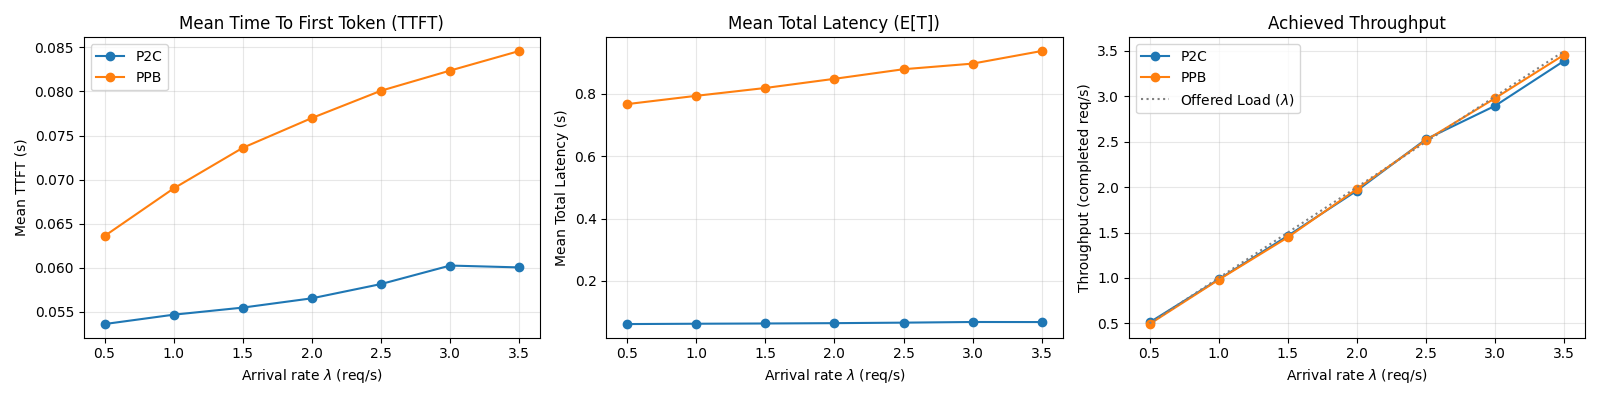

Across all metrics, a consistent pattern emerges:
- P2C provides lower TTFT and lower total latency.
- PPB introduces additional waiting due to batching and synchronization.
- Throughput remains approximately equal to $$\lambda$$ under both policies.

The following sections analyze these results in detail.

---

### 5.1 Mean Time To First Token (TTFT)

The left plot shows the **mean Time To First Token (TTFT)** as a function of the
arrival rate $\lambda$.

**What the plot shows**

- TTFT increases with $\lambda$ for both scheduling policies.
- At every arrival rate, PPB has higher TTFT than P2C.
- The gap between PPB and P2C becomes larger as $\lambda$ increases.

**Why this happens**

Under **P2C**, once a request reaches the GPU, it begins processing immediately.
The request does not need to coordinate with other requests, so TTFT is primarily
determined by how long the request waits for the GPU to become free and how long
the prompt portion of computation takes.

Under **PPB**, a request must wait to be included in a prefill batch. Even if the
GPU is actively decoding other requests, PPB prioritizes prefill when new
requests arrive. As a result, a request may wait:
1. for enough requests to form a batch,
2. for earlier batches to finish,
3. for the entire prefill batch to complete before any token is generated.

As the arrival rate increases, queues grow and batching delays become more
pronounced, leading to higher TTFT.

**Interpretation**

PPB sacrifices responsiveness in exchange for batching structure. If early user
feedback is important, this increase in TTFT is a significant drawback.

---

### 5.2 Mean Total Latency

The middle plot shows **mean total latency**, defined as the time from request
arrival to full completion.

**What the plot shows**

- Total latency increases with $\lambda$ under both policies.
- PPB exhibits substantially higher total latency than P2C across all tested
  arrival rates.
- The latency gap widens as the system load increases.

**Why this happens**

The primary reason is **synchronization overhead** in PPB. During decode, PPB
advances requests one token per synchronized batch round. Each request must wait
for other requests in the batch, even if it could otherwise continue generating
tokens.

Additionally, PPB prioritizes prefill over decode. When new requests arrive, the
GPU may interrupt ongoing decode rounds to execute new prefill batches, further
delaying completion for existing requests.

In contrast, P2C avoids these delays entirely. Once a request begins service, it
runs to completion without interference from other requests.

**Interpretation**

Although PPB batches GPU work, the coordination and waiting it introduces
outweigh any batching benefit in this workload regime, resulting in higher
end-to-end latency.

---

### 5.3 Throughput

The right plot shows **throughput**, measured as completed requests per second.

**What the plot shows**

- Throughput under both policies closely tracks the offered load $\lambda$.
- Neither policy exhibits a clear throughput advantage over the other.
- Throughput does not plateau within the tested range of $\lambda$.

**What this means**

When throughput is approximately equal to $\lambda$, it indicates that:
- the system is completing requests as fast as they arrive,
- queues are not growing without bound,
- the GPU is not fully saturated.

Because the workload is homogeneous and decode is relatively short, batching does
not meaningfully increase effective capacity. As a result, PPB does not improve
throughput relative to P2C.

**Interpretation**

In this experiment, batching does not allow the system to handle more requests per
second. Its main effect is to increase waiting time, not capacity.

---

### 5.4 Summary of Observed Tradeoffs

Taken together, the results reveal a clear tradeoff:

- **P2C** minimizes TTFT and total latency.
- **PPB** introduces batching and synchronization delays that significantly
  degrade latency.
- **Throughput is similar** under both policies in the tested workload regime.

These findings show that batching is not automatically beneficial. Under
homogeneous workloads and moderate load, minimizing coordination can deliver
better user-perceived performance without reducing throughput.


---
## 6. Steady-State Performance Analysis

Earlier analysis based on approximately 2,000 completed requests provided initial evidence that the P2C policy outperforms PPB in terms of response time and tail latency. However, short-run simulations may still be influenced by transient effects and sampling variability. In this section, we evaluate **steady-state performance** using long-run simulations with warm-up removal and multiple replications, and we compare these results against the earlier 2,000-sample findings.

---
### 6.1 Methodology

For each arrival rate $\lambda \in [0.5, 3.5]$ req/s, the simulator is run long enough to reach steady state. An initial warm-up period is discarded to remove bias from the empty-system start. Performance metrics are then aggregated across replications, and 95% confidence intervals are computed from steady-state observations.

We focus on the following metrics:
- Mean **TTFT (Time to First Token)**,
- Mean **total latency**,
- **P95 total latency** (tail latency),
- **Throughput**.

---
### 6.2 Comparison with 2,000-Sample Results

The steady-state results confirm the qualitative conclusions reached in the earlier 2,000-sample simulations. In both analyses:
- **P2C consistently outperforms PPB** in TTFT, mean latency, and tail latency.
- Throughput closely follows the offered load for both policies.

Compared to the 2,000-sample runs, steady-state estimates exhibit lower variability and tighter confidence intervals. In some cases, steady-state latency values are slightly higher, indicating that the short-run simulations modestly underestimated long-run waiting times, particularly for PPB at higher arrival rates. Importantly, the relative ordering between policies remains unchanged.

---
### 6.3 Mean TTFT and Mean Latency in Steady State

Figure 6.1 shows steady-state **mean TTFT** and **mean total latency** as a function of arrival rate. Under P2C, mean TTFT increases slowly as load grows, remaining relatively low across the full range of $\lambda$. In contrast, PPB shows a noticeably steeper increase in TTFT, indicating greater sensitivity to congestion.

A similar pattern appears for mean total latency. P2C maintains stable and low latency even at higher arrival rates, while PPB experiences significantly larger delays. These trends are consistent with the earlier 2,000-sample results but are more clearly separated in steady state.

*Note:* Error bars representing 95% confidence intervals are included in the analysis but are not visually distinguishable in the figure due to their small width relative to the marker size.

![Mean TTFT and Mean Latency vs Arrival Rate](https://raw.githubusercontent.com/cs2278-cornell/ORIE_4580_Final_Project/9b7fcf61f3a75f110a8473ef76594ea36a54a4da/Mean%20TTFT%20and%20Mean%20Latency%20vs%20Arrival%20Rate.png)
---
### 6.4 Tail Latency (P95) Behavior

Figure 6.2 presents the steady-state **P95 total latency**. The difference between the two policies is especially pronounced in the tail. Under P2C, P95 latency grows gradually with arrival rate and remains tightly controlled. Under PPB, P95 latency increases rapidly, exceeding one second at higher load levels.

The persistence of this gap in steady state confirms that the tail latency penalties observed for PPB in the 2,000-sample simulations are not transient artifacts, but structural properties of the policy under sustained load.

*Note:* As with the mean metrics, confidence intervals are present but visually indistinguishable due to their narrow width.

![P95 Total Latency vs Arrival Rate](https://raw.githubusercontent.com/cs2278-cornell/ORIE_4580_Final_Project/9b7fcf61f3a75f110a8473ef76594ea36a54a4da/P95%20Total%20Latency%20vs%20Arrival%20Rate.png
)
---
### 6.5 Summary of Steady-State Findings

The steady-state analysis reinforces and strengthens the conclusions drawn from the earlier short-run simulations:
- **P2C dominates PPB** across all latency-related metrics in steady state.
- Latency degradation under PPB persists and worsens as load increases.
- Throughput remains comparable across policies, indicating that performance differences arise from queueing behavior rather than capacity limitations.

Overall, steady-state results confirm that **P2C provides more robust, predictable, and scalable performance** for sustained operation.

---
### 6.6 Steady-State Performance Summary (Numerical Results)

Table 6.1 reports the steady-state performance metrics for both policies across arrival rates. Values represent steady-state means after warm-up removal and aggregation across replications. Throughput is reported in requests per second.

| Arrival Rate λ (req/s) | Policy | Mean TTFT (s) | P95 TTFT (s) | Mean Latency (s) | P95 Latency (s) | Throughput (req/s) |
|------------------------|--------|---------------|--------------|------------------|-----------------|--------------------|
| 0.50 | P2C | 0.0537 | 0.0527 | 0.0621 | 0.0611 | 0.5013 |
| 0.50 | PPB | 0.0638 | 0.0958 | 0.7663 | 0.8499 | 0.5019 |
| 1.00 | P2C | 0.0547 | 0.0643 | 0.0631 | 0.0727 | 0.9978 |
| 1.00 | PPB | 0.0693 | 0.0998 | 0.7927 | 0.8963 | 1.0017 |
| 1.50 | P2C | 0.0558 | 0.0829 | 0.0642 | 0.0913 | 1.4948 |
| 1.50 | PPB | 0.0736 | 0.1016 | 0.8193 | 0.9443 | 1.5017 |
| 2.00 | P2C | 0.0570 | 0.0922 | 0.0654 | 0.1006 | 1.9964 |
| 2.00 | PPB | 0.0769 | 0.1075 | 0.8457 | 0.9941 | 1.9955 |
| 2.50 | P2C | 0.0582 | 0.0986 | 0.0666 | 0.1071 | 2.4924 |
| 2.50 | PPB | 0.0796 | 0.1122 | 0.8744 | 1.0465 | 2.5066 |
| 3.00 | P2C | 0.0595 | 0.1031 | 0.0680 | 0.1116 | 2.9955 |
| 3.00 | PPB | 0.0817 | 0.1174 | 0.9038 | 1.0985 | 3.0008 |
| 3.50 | P2C | 0.0611 | 0.1069 | 0.0695 | 0.1154 | 3.5024 |
| 3.50 | PPB | 0.0835 | 0.1215 | 0.9375 | 1.1685 | 3.4893 |

*Table 6.1: Steady-state performance metrics for P2C and PPB across arrival rates.*


---
## 7. Recommendations and Practical Implications

The simulation results provide clear guidance on how scheduling policy choices
affect user experience and system behavior under the modeled conditions. This
section translates the observed results into practical recommendations.

---
### 7.1 When Process-to-Completion (P2C) Is the Better Choice

Under the tested workload assumptions—homogeneous prompt lengths, homogeneous
output lengths, and moderate arrival rates—the **Process-to-Completion (P2C)**
policy consistently outperforms PPB in terms of latency-related metrics.

Specifically:
- P2C delivers **lower Time To First Token (TTFT)**, meaning users receive visible
  feedback more quickly.
- P2C achieves **lower total latency**, allowing responses to complete sooner.
- P2C achieves **comparable throughput** to PPB, indicating no loss in capacity.

The key reason is that P2C minimizes coordination and synchronization overhead.
Once a request begins service, it is not delayed by other requests entering the
system. This makes P2C particularly suitable for:
- interactive applications (e.g., chat, code assistants),
- latency-sensitive user experiences,
- systems operating below or near moderate load.

In these regimes, the simplicity of P2C is not a weakness but an advantage.

---

### 7.2 When Batching-Based Policies Like PPB May Be Useful

Although PPB performs worse in this experiment, this does not imply that batching
is inherently undesirable. Instead, it highlights that **batching is
workload-dependent**.

PPB may provide benefits in scenarios that differ from the tested setup, such as:
- **Decode-heavy workloads**, where output length $B$ is much larger than prompt
  length $L$.
- **Highly variable request sizes**, where batching can smooth GPU utilization.
- **Near-saturation regimes**, where the GPU becomes the bottleneck and parallel
  execution amortizes overhead.
- **Throughput-oriented systems**, where maximizing completed requests per second
  is more important than individual response time.

In such cases, the additional waiting introduced by batching may be offset by
higher effective GPU utilization. These regimes represent natural extensions of
this work.

---

### 7.3 Interpretation of Throughput Results

A central observation from the throughput plot is that both P2C and PPB achieve
throughput close to the offered load $\lambda$ across all tested arrival rates.

This implies:
- the system is not overloaded,
- queues do not grow without bound,
- batching is not required to maintain stability.

From a systems perspective, this result is crucial: **when throughput is already
limited by arrival rate rather than service capacity, batching cannot improve
performance**. In such cases, batching primarily reshapes latency rather than
increasing capacity.

---

### 7.4 Limitations of the Current Analysis

The conclusions above are conditional on the modeling assumptions. In particular:
- workloads are homogeneous,
- only a single GPU is modeled,
- batching thresholds and service parameters are fixed,
- no adaptive scheduling is used.

These limitations do not invalidate the results, but they clarify their scope.
The value of the simulator lies in its ability to relax these assumptions in
future experiments.

---

## 8. Final Conclusions

This project set out to understand how GPU scheduling policies affect the balance
between latency and throughput in LLM inference systems. By building and
validating a discrete-event simulation, we were able to isolate the impact of
scheduling decisions under controlled conditions.

The key conclusions are:

1. **Batching increases latency under homogeneous workloads.**  
   Prefill batching and synchronized decode rounds introduce waiting and
   coordination overhead that significantly increase both TTFT and total latency.

2. **Batching does not improve throughput in the tested regime.**  
   When the system is not saturated, both policies achieve throughput close to
   $\lambda$, making batching unnecessary for capacity reasons.

3. **Simple scheduling can outperform complex scheduling.**  
   The P2C policy, despite its simplicity, delivers better user-perceived
   performance without sacrificing throughput.

4. **The effectiveness of batching is context-dependent.**  
   Batching should be viewed as a tool, not a default optimization. Its benefits
   depend on workload characteristics, saturation level, and system objectives.

Overall, this work demonstrates that **careful simulation is essential for
evaluating system design choices**. Intuitive optimizations such as batching may
appear beneficial, but their true impact depends on detailed interactions between
arrival processes, service dynamics, and scheduling logic. The simulation
framework developed here provides a foundation for exploring these interactions
in more complex and realistic settings.
